# **Universidad Nacional de Rosario - Facultad de Ciencias Exactas, Ingeniería y Agrimensura.**

Tecnicatura Universitaria en Inteligencia Artificial.

Procesamiento del Lenguaje Natural: Trabajo Práctico N°1 Parte 3

Juego: Cascadia.

*Integrantes:*

Agustín Arenas, Daniela Dito, Santiago Giaveno, Brisa Moresco

# **PARTE 3: RELACIONES**

Relaciones siendo cascadia el centro de las
mismas. Tomando los desiñadores, los desarrolladores y artistas. Relacionando con otros juegos que participaron tambien

In [1]:
# 🔧 INSTALACIÓN DE CHROME y CHROMEDRIVER COMPATIBLES
!wget -q https://storage.googleapis.com/chrome-for-testing-public/122.0.6261.111/linux64/chrome-linux64.zip
!wget -q https://storage.googleapis.com/chrome-for-testing-public/122.0.6261.111/linux64/chromedriver-linux64.zip
!unzip -q chrome-linux64.zip
!unzip -q chromedriver-linux64.zip
!mv chrome-linux64 chrome
!mv chromedriver-linux64/chromedriver chrome/

# 🔄 Variables de entorno
import os
os.environ['PATH'] += ":/content/chrome"

# 📦 Instala Selenium
!pip install selenium > /dev/null

In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
#Funcion para iniciar driver
def iniciar_driver():
    opciones = Options()
    opciones.binary_location = "/content/chrome/chrome"
    opciones.add_argument("--headless=new")
    opciones.add_argument("--no-sandbox")
    opciones.add_argument("--disable-dev-shm-usage")

    service = Service("/content/chrome/chromedriver")
    driver = webdriver.Chrome(service=service, options=opciones)
    return driver

In [5]:
import pandas as pd
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By

# --- PARTE 1: Extraemos créditos de Cascadia
url = "https://boardgamegeek.com/boardgame/295947/cascadia/credits"
driver = iniciar_driver()
driver.get(url)
time.sleep(4)

personas_info = []
relacion = []
# Roles importantes a incluir
roles_permitidos = {
    "Designer": "diseño",
    "Solo Designer": "diseño",
    "Developers": "desarrollo",
    "Artist": "ilustro"
}
roles_divs = driver.find_elements(By.CLASS_NAME, 'outline-item-title')
# Verificar cuántos roles se encontraron
for rol_div in roles_divs:
    try:
         # Obtener el nombre del rol (ej: Designer)
        titulo = rol_div.text.strip()

        if titulo not in roles_permitidos:

            continue  # Ignorar si no es un rol importante
        rol = roles_permitidos[titulo]  # Ej: "diseñado"
        descripcion_div = rol_div.find_element(By.XPATH, 'following-sibling::div[@class="outline-item-description"]')
        personas = descripcion_div.find_elements(By.TAG_NAME, 'a')
        for persona in personas:
            nombre = persona.text.strip()
            link = persona.get_attribute("href")
            if nombre and link:
                relacion.append(['Cascadia', f'{rol}', nombre])
                personas_info.append({
                    "nombre": nombre,
                    "rol": rol,
                    "perfil": link
                })
    except Exception as e:
        continue

# --- PARTE 2: Entramos a cada perfil y buscamos juegos relacionados
relaciones = []
relaciones_completas = []
for persona in personas_info:
    driver.get(persona["perfil"])
    time.sleep(3)

    try:
        # Extrae juegos relacionados desde el perfil
        juegos = driver.find_elements(By.CSS_SELECTOR, 'a[href*="/boardgame/"]')
        for juego in juegos:
            nombre_juego = juego.text.strip().split("\n")[0]
            href = juego.get_attribute("href")
            if nombre_juego and "/boardgame/" in href:
                relaciones.append([
                    persona["nombre"],
                    f'fue {persona["rol"]} de',
                    nombre_juego
                ])
    except Exception as e:
        print(f"No se pudo procesar: {persona['nombre']} - {e}")
        continue
# --- PARTE 3: Encadenamos relaciones y guardamos en CSV
relaciones_completas = []

# Creamos un índice por persona para buscar más rápido sus juegos
from collections import defaultdict

juegos_por_persona = defaultdict(list)
for r in relaciones:
    nombre = r[0]  # persona
    juegos_por_persona[nombre].append([r[0], r[1], r[2]])

# Encadenamos: primero Cascadia → persona, luego persona → juegos
for r in relacion:
    juego, rol, persona = r  # Ej: Cascadia, diseño, Juan
    relaciones_completas.append([juego, rol, persona])

    if persona in juegos_por_persona:
        relaciones_completas.extend(juegos_por_persona[persona])  # Juan → diseño → juegos

# Mapas para normalizar los verbos
pasiva = {
    "diseño": "fue diseñado por",
    "ilustro": "fue ilustrado por",
    "desarrollo": "fue desarrollado por"
}

activa = {
    "diseño": "diseñó",
    "ilustro": "ilustró",
    "desarrollo": "desarrolló"

}

compartido = {
    "diseño": "comparte diseñador con",
    "ilustro": "comparte ilustrador con",
    "desarrollo": "comparte desarrollador con"
}

relaciones_finales = []

for sujeto1, relacion, sujeto2 in relaciones_completas:
    nueva_relacion = relacion  # por defecto

    # Caso 1: relaciones del juego Cascadia (forma pasiva)
    if sujeto1 == "Cascadia" and relacion in pasiva:
        nueva_relacion = pasiva[relacion]

    # Caso 2: relaciones del tipo "fue diseño de"
    elif relacion.startswith("fue") and sujeto1 != "Cascadia":
        rol = relacion.replace("fue ", "").replace(" de", "")
        if rol in activa:
            nueva_relacion = activa[rol]

    # Agregar manteniendo el orden original
    relaciones_finales.append([sujeto1, nueva_relacion, sujeto2])
driver.quit()

# Creamos DataFrame
df = pd.DataFrame(relaciones_finales, columns=["SUJETO1", "RELACION", "SUJETO2"])

# Guardamos
df.to_csv("relaciones_personas.csv", index=False, sep=';',encoding='utf-8-sig')

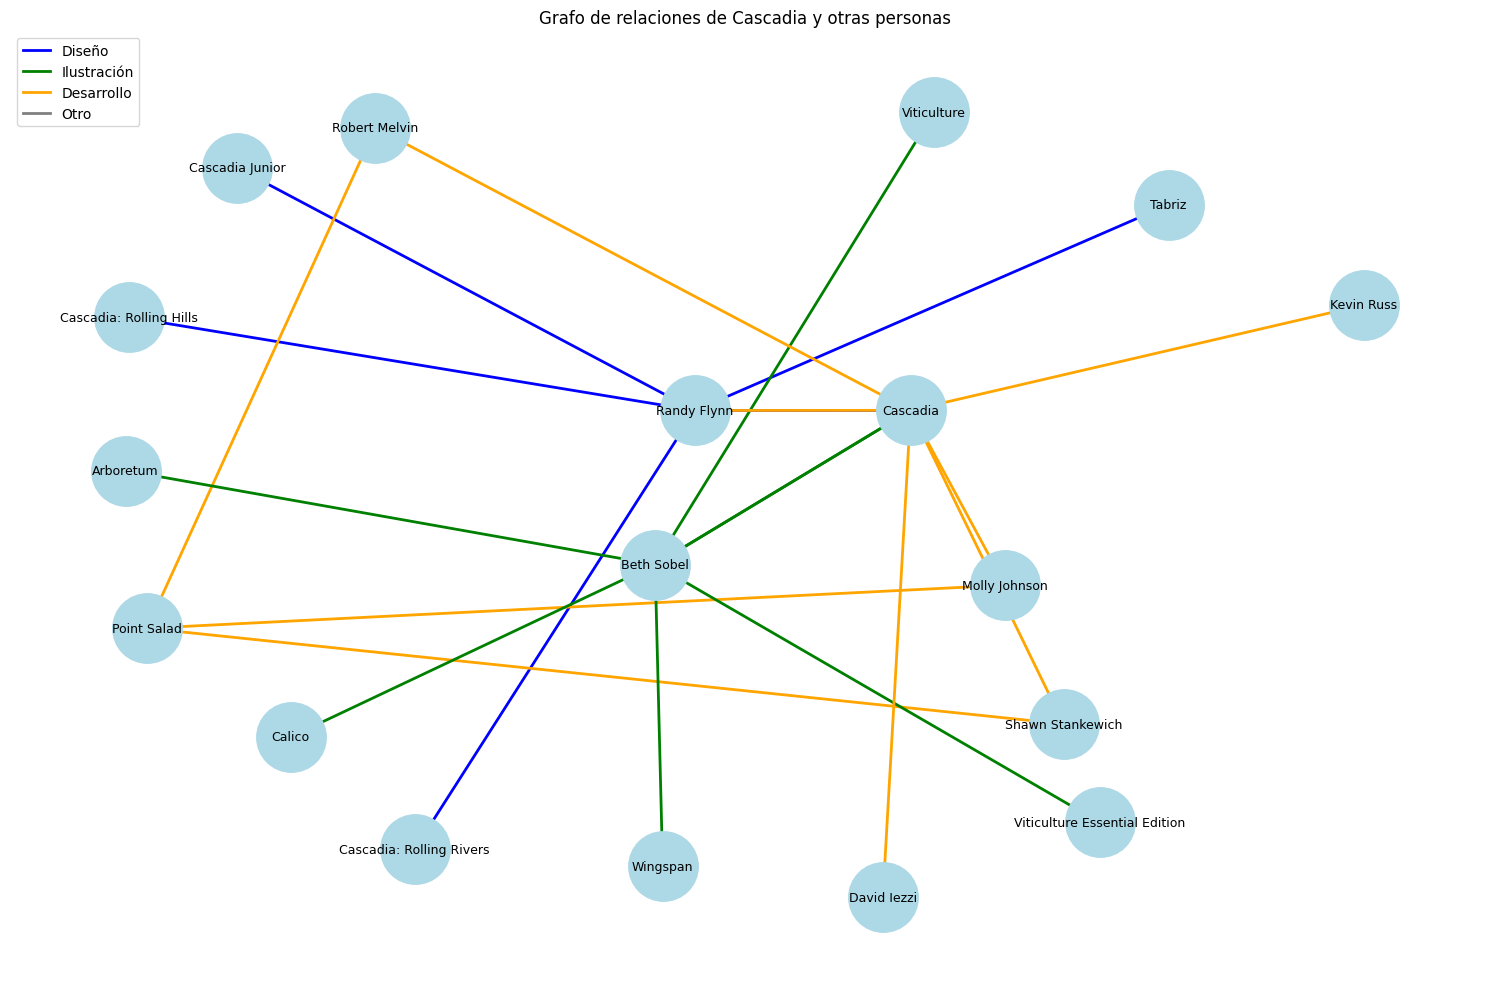

In [6]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# Crear grafo dirigido
G = nx.DiGraph()

# Colores para cada tipo de relación
colores_relaciones = {
    "fue diseñado por": "blue",
    "diseñó": "blue",
    "fue ilustrado por": "green",
    "ilustró": "green",
    "fue desarrollado por": "orange",
    "desarrolló": "orange",
    # Agregar más si hace falta
}

# Agregar nodos y aristas
for _, row in df.iterrows():
    s1, rel, s2 = row["SUJETO1"], row["RELACION"], row["SUJETO2"]
    color = colores_relaciones.get(rel, "gray")
    G.add_edge(s1, s2, label=rel, color=color)
# Posicionamiento
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=1.5, seed=42)

# Dibujar nodos
nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=2500)
nx.draw_networkx_labels(G, pos, font_size=9)

# Dibujar aristas por color
edges = G.edges(data=True)
for rel in set(colores_relaciones):
    edges_filtradas = [(u, v) for u, v, d in edges if d["label"] == rel]
    nx.draw_networkx_edges(G, pos, edgelist=edges_filtradas,
                           edge_color=colores_relaciones[rel], width=2)

# Agregar leyenda
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Diseño'),
    Line2D([0], [0], color='green', lw=2, label='Ilustración'),
    Line2D([0], [0], color='orange', lw=2, label='Desarrollo'),
    Line2D([0], [0], color='gray', lw=2, label='Otro')
]
plt.legend(handles=legend_elements, loc='upper left')
plt.title("Grafo de relaciones de Cascadia y otras personas")
plt.axis('off')
plt.tight_layout()
plt.show()

Grafo dirigido para visualizar las diferentes relaciones del juego Cascadia con sus diseñadores, ilustradores y desarrolladores

In [11]:
import pandas as pd

# Cargar CSV
df = pd.read_csv("relaciones_personas.csv")

# Filtrar relaciones que parten desde Cascadia
df_cascadia = df[df["SUJETO1"] == "Cascadia"]

# Contar tipos de relaciones
conteo_roles = df_cascadia["RELACION"].value_counts()

# Mostrar resumen
print("Resumen de relaciones de Cascadia:")
for relacion, cantidad in conteo_roles.items():
    print(f"- {relacion.capitalize()}: {cantidad}")

Resumen de relaciones de Cascadia:
- Fue desarrollado por: 6
- Fue diseñado por: 2
- Fue ilustrado por: 1
